## Implemented ACM validation

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob as glob
import h5py
from gqp_mc import data as Data 
from gqp_mc import fitters as Fitters
from matplotlib import cm
from matplotlib import colors
from seaborn import cm as cmap

In [2]:
specs,meta = Data.Spectra(sim='lgal',noise = 'none', lib = 'bc03', sample = 'mini_mocha')
photo, _ = Data.Photometry(sim='lgal', noise= 'none', lib='bc03', sample='mini_mocha') 
input_mass = meta['logM_total'][:]

In [3]:
class convergence_plotter_single2():
    def __init__(self,walkers,num_run,data_dir,ID):
        self.num_walkers = walkers
        self.num_run = num_run
        self.data_dir = data_dir
        self.files = []
        self.ID = ID
        
    def opener(self, pr = False):
        f = [x for x in glob.glob(f'{self.data_dir}/*.{self.ID}.mcmc.hdf5')]  
        f.sort()
        if pr:
            print(f)
        files = []
        
        for i in f:
            file = h5py.File(i,'r')
            files.append(file)
        
        self.files = files
        return bool(len(f))
    
    def avg_perc_plot(self,ax, gal_idx, spec_photo,step=1000, flag = ''):
        data = self.files[0]['mcmc_chain'][...][:,0]
        perc_err = []
        
        y,up_perc,lo_perc = [], [], []
        length = len(data)
        inc = length//step
        x_axis = (np.arange(inc)+1)*step
        for n in range(inc):
            up = np.percentile(data[:step*(1+n)],84.1)
            lo = np.percentile(data[:step*(1+n)],15.9)
            med = np.median(data[:step*(1+n)])
            up_perc.append(up-med)
            lo_perc.append(med-lo)
            y.append(med)

        yerr = np.vstack((up_perc,lo_perc))    
        ax.set_xlabel('$N_{iteration}$')
        ax.set_ylabel('Median')
        ax.grid()
        ax.axhline(input_mass[gal_idx], lw = 1, c = 'r')
        ax.text(length,y[-1],f'{y[-1]}')
        ax.errorbar(x_axis,y,yerr=yerr,fmt = '.k', ecolor = 'gray', elinewidth=1,capsize=1)
    
    def get_output(self):
        data = self.files[0]['mcmc_chain'][...][:,0]
        med = np.median(data)
        return med 
    def get_err(self):
        data = self.files[0]['mcmc_chain'][...][:,0]
        med = np.median(data)
        up = np.percentile(data,84.1) - med
        lo = med - np.percentile(data, 15.9)
        return up, lo
    
    def get_length(self):
        data = self.files[0]['mcmc_chain'][...][:,0]
        return len(data)

In [4]:
path = os.environ.get('GQPMC_DIR') + 'mini_mocha/ispeculator/ACM/run_03/specphoto_0_96/'

In [5]:
compare = []
compare_up = []
compare_lo = []
comp_length = []
comp_missing = []
for i in range(97):
    file = convergence_plotter_single2(40,100000,os.environ.get('GQPMC_DIR')+'mini_mocha/ispeculator/iSpeculator_validation/specphoto_0_96/',i)
    if file.opener():
        compare.append(file.get_output())
        up, lo = file.get_err()
        compare_up.append(up)
        compare_lo.append(lo)
        comp_length.append(file.get_length())
    else:
        compare.append(-1)
        compare_up.append(0)
        compare_lo.append(0)
        comp_length.append(-1e8)
        comp_missing.append(i)

In [6]:
icefire = cmap.icefire

In [11]:
valid_set = []
ACF_missing = []
for i in range(97):
    file = convergence_plotter_single2(40,1000000,path,i)
    if file.opener(pr = False):
        valid_set.append(file)
    else:
        valid_set.append('N/A')

meds = []
ups = []
los = []
ACF_length = []
ACF_missing = []
for i,s in enumerate(valid_set):
    if s != 'N/A':
#         fig, ax = plt.subplots(1,1)
#         s.avg_perc_plot(ax,i,'specphoto',10000)
        meds.append(s.get_output())
        up, lo = s.get_err()
        ups.append(up)
        los.append(lo)
        ACF_length.append(s.get_length())
    else:
        meds.append(-1)
        up,lo = (0,0)
        ups.append(up)
        los.append(lo)
        ACF_length.append(-1e8)
        ACF_missing.append(i)
        
print(f'ACF missing {ACF_missing}\nCompare set missing {comp_missing}')

ACF missing [19, 33, 64]
Compare set missing [19, 33, 38, 42, 64]


In [12]:
a = np.empty(len(ACF_length))
b = comp_length[:len(ACF_length)]
for i,acf_l in enumerate(ACF_length):
    if acf_l < 0:
        a[i] = 0
    else:
        if b[i] < 0:
            a[i] = 0
        else:
            a[i] = acf_l/b[i]

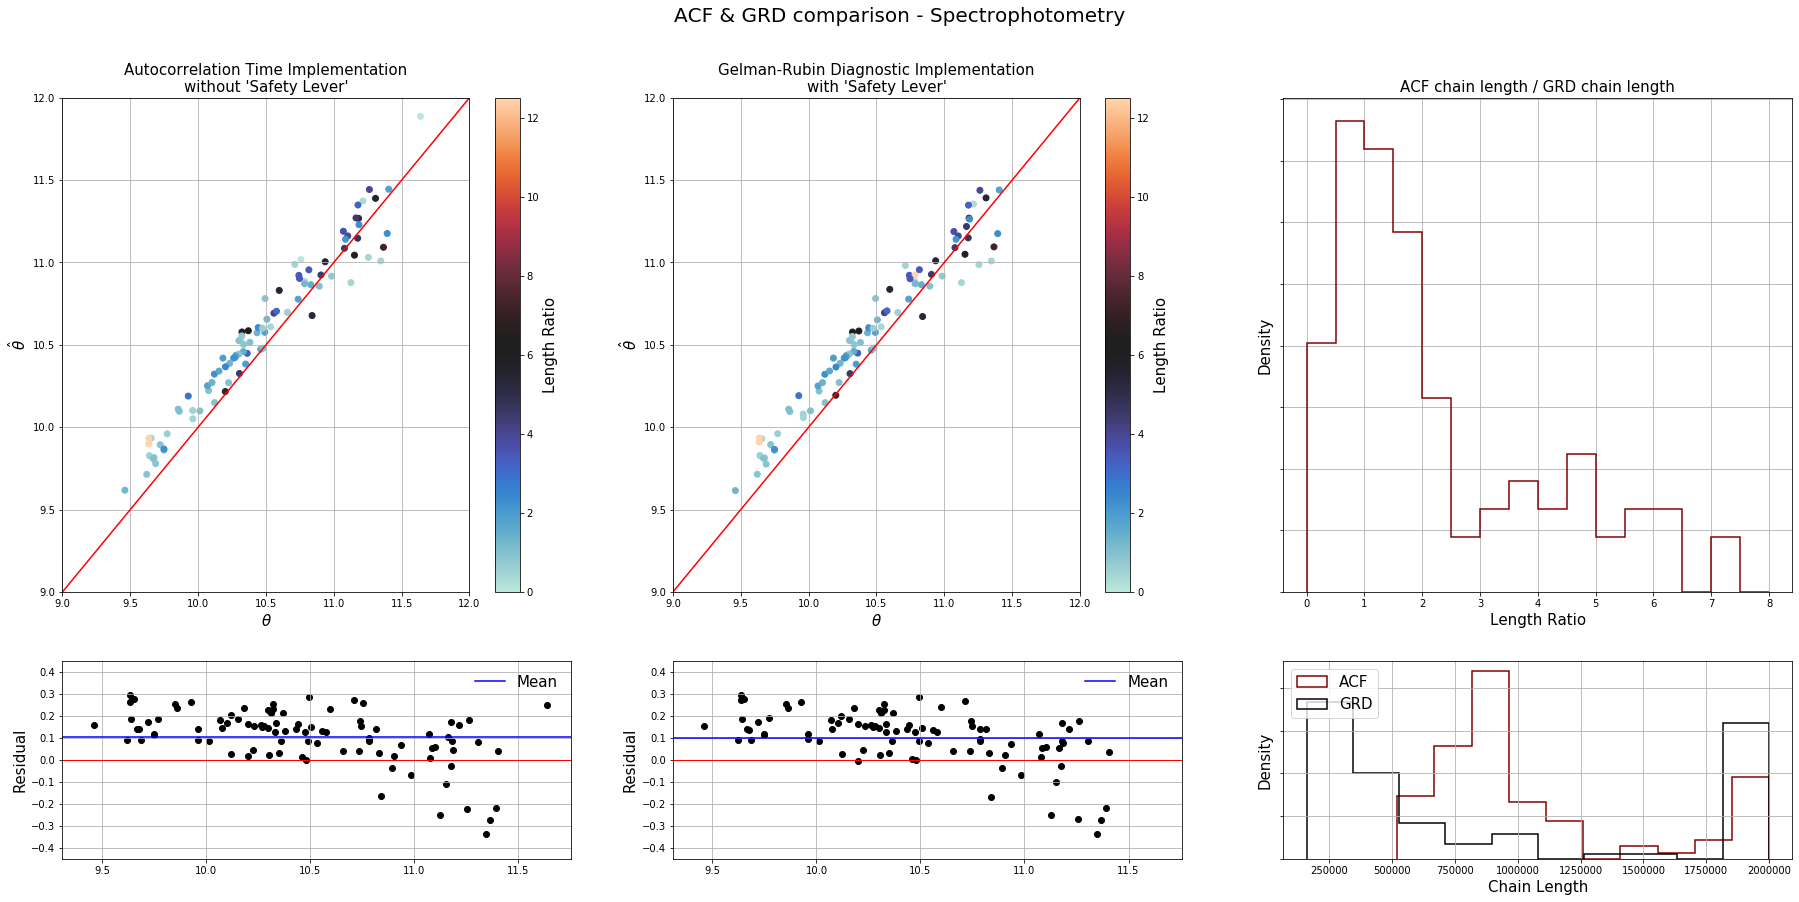

In [13]:
fig, axs = plt.subplots(2,3,figsize=(31,14), gridspec_kw={'height_ratios' : (10,4)})
xlim = axs[0,0].set_xlim(9,12)
axs[0,0].set_ylim(xlim)
axs[0,1].set_xlim(xlim)
axs[0,1].set_ylim(xlim)

for ax in axs:
    for x in ax:
        x.grid()


mask = (np.array(meds) != -1) & (np.array(compare[:len(meds)]) != -1)
# axs[0,0].errorbar(input_mass[:len(meds)],meds,yerr=(ups,los), elinewidth = 1, fmt = 'o', color = c,capsize = 2)
# axs[0,1].errorbar(input_mass[:len(meds)],compare[:len(meds)],yerr=(compare_up[:len(meds)], compare_lo[:len(meds)]), fmt = 'ok',elinewidth = 1, capsize = 2)
im1 = axs[0,0].scatter(input_mass[:len(meds)],meds, c = a, cmap = icefire)
im2 = axs[0,1].scatter(input_mass[:len(meds)],compare[:len(meds)],c = a, cmap = icefire)

axs[0,2].hist(a[a != 0], bins = np.linspace(0,8.0,17), histtype = 'step', color = 'maroon', density = True, lw = 1.5, zorder = 10)
axs[0,2].set_title('ACF chain length / GRD chain length', fontsize = 15)

axs[1,0].set_ylim(-0.45,0.45)
axs[1,1].set_ylim(-0.45,0.45)

axs[1,0].scatter(input_mass[:len(meds)],np.array(meds)-np.array(input_mass[:len(meds)]), c = 'k')
axs[1,1].scatter(input_mass[:len(meds)],np.array(compare[:len(meds)])-np.array(input_mass[:len(meds)]), c = 'k')
axs[1,2].hist(np.array(ACF_length)[mask], histtype = 'step', density = True, color = 'maroon', lw = 1.5, label = 'ACF')
axs[1,2].hist(np.array(comp_length)[:len(meds)][mask], histtype = 'step', density = True, color = 'k', lw = 1.5, label = 'GRD')
axs[1,2].legend(frameon = True, fontsize = 15)
axs[1,2].set_yticklabels(np.array([]))
axs[0,2].set_yticklabels(np.array([]))

cb1 = fig.colorbar(im1, ax = axs[0,0])
cb2 = fig.colorbar(im2, ax = axs[0,1])

cb1.set_label('Length Ratio', fontsize = 15)
cb2.set_label('Length Ratio', fontsize = 15)

axs[0,0].set_title('Autocorrelation Time Implementation\nwithout \'Safety Lever\'', fontsize = 15)
axs[0,1].set_title('Gelman-Rubin Diagnostic Implementation\nwith \'Safety Lever\'', fontsize = 15)

axs[0,0].set_xlabel('$\\theta$', fontsize = 15)
axs[0,0].set_ylabel('$\hat{\\theta}$', fontsize = 15)

axs[0,1].set_xlabel('$\\theta$', fontsize = 15)
axs[0,1].set_ylabel('$\hat{\\theta}$', fontsize = 15)

axs[0,2].set_xlabel('Length Ratio', fontsize = 15)
axs[0,2].set_ylabel('Density', fontsize = 15)

axs[1,0].axhline(0,c = 'r', lw = 1)
axs[1,1].axhline(0,c = 'r', lw = 1)

mask2 = np.array(meds) != -1
mask3 = np.array(compare) != -1

axs[1,0].axhline(np.mean(np.array(meds)[mask2] -np.array(input_mass[:len(meds)])[mask2]), c = 'b', lw = 1.5, label = 'Mean')
axs[1,1].axhline(np.mean(np.array(compare)[mask3]-np.array(input_mass[:len(compare)])[mask3]), c = 'b', lw = 1.5, label = 'Mean')
axs[1,0].legend(frameon = False, fontsize = 15)
axs[1,1].legend(frameon = False, fontsize = 15)

axs[0,0].plot([9,12],[9,12], c = 'r', lw = 1.5)
axs[0,1].plot([9,12],[9,12], c = 'r', lw = 1.5)

axs[1,2].set_ylabel('Density', fontsize = 15)
axs[1,1].set_ylabel('Residual', fontsize = 15)
axs[1,0].set_ylabel('Residual', fontsize = 15)

axs[1,2].set_xlabel('Chain Length', fontsize = 15)

fig.suptitle('ACF & GRD comparison - Spectrophotometry',  y= 0.97, fontsize = 20)
plt.savefig('specphoto_comparison.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()